## Displaying ED predictions

- an end in itself
- template up how to build a dash display

Load standard libraries plus those specified in poetry.toml

In [4]:
import os
import pandas as pd
import numpy as np
import json
from pathlib import Path
from datetime import datetime, date
import warnings

import plotly.graph_objects as go
import plotly.express as px
from ridgeplot import ridgeplot

Run this file as if it was in the 'app' folder so that it's easier to migrate your code later on

In [3]:
# check that you're starting from the notebooks folder
# else subsequent relative imports won't work
# moreover this means that code here will behave wrt to relative imports in a similar manner to app code
app_path = Path("__file__").parent.resolve().parent / 'app' 
assert app_path.exists()
os.chdir(app_path)
print(Path.cwd())

/Users/steve/code/hylode/dashRep/app


Now import the 'app' and configuration settings

In [ ]:
import app
from config.config import ConfigFactory
conf = ConfigFactory.factory()

Run a query against the live data if in production

In [ ]:
if not conf.DEV:
    # Environment variables stored in conf.SECRETS
    # Construct the PostgreSQL connection
    uds_host = conf.SECRETS['EMAP_DB_HOST']
    uds_name = conf.SECRETS['EMAP_DB_NAME']
    uds_port = conf.SECRETS['EMAP_DB_PORT']
    uds_user = conf.SECRETS['EMAP_DB_USER']
    uds_passwd = conf.SECRETS['EMAP_DB_PASSWORD']

    emapdb_engine = create_engine(f'postgresql://{uds_user}:{uds_passwd}@{uds_host}:{uds_port}/{uds_name}')
    q = Path("../notebooks/sql/ed.sql").read_text()
    df = pd.read_sql_query(q, emapdb_engine)
    df.to_csv("../data/secret/ed_agg_30d_sample.csv", index=False)

Read in data

In [366]:
df = pd.read_csv("../data/secret/ed_agg_30d_sample.csv", parse_dates=['extract_dttm'])

Prepare the data 
- prepare the 'hour' the model ran so you can work compare models from the same time of day
- convert date to time offset in days

In [367]:
df['hour'] = df.extract_dttm.round('1H').dt.hour
df['dow'] = df.extract_dttm.dt.dayofweek # Monday = 0, Sunday = 6
df['date'] = df.extract_dttm.round('1D').dt.date
df['days'] = (df.extract_dttm.max() - df.extract_dttm).round('1D').dt.days.astype(int)
df = df.loc[df.contrib == 'All patients', ['extract_dttm', 'days', 'date', 'dow', 'hour', 'num_adm_pred', 'prob_this_num', 'probs']]


### Simple plot of probability distribution for one forecast
- return `df0`: a dataframe with the most recent 8 hour forecast for all patients
- then prepare a simple plot of the probability distribution

In [368]:
df0 = df.loc[(df.extract_dttm == df.extract_dttm.max())]
df0.head()

,extract_dttm,days,date,dow,hour,num_adm_pred,prob_this_num,probs
11678,2022-01-04 22:00:09.955230+00:00,0,2022-01-05,1,22,0,1.000000,1.720000e-11
11679,2022-01-04 22:00:09.955230+00:00,0,2022-01-05,1,22,1,1.000000,6.520000e-10
11680,2022-01-04 22:00:09.955230+00:00,0,2022-01-05,1,22,2,1.000000,1.190000e-08
11681,2022-01-04 22:00:09.955230+00:00,0,2022-01-05,1,22,3,1.000000,1.380000e-07
11682,2022-01-04 22:00:09.955230+00:00,0,2022-01-05,1,22,4,0.999999,1.160000e-06


In [398]:
df0.iloc[0]['hour']

22

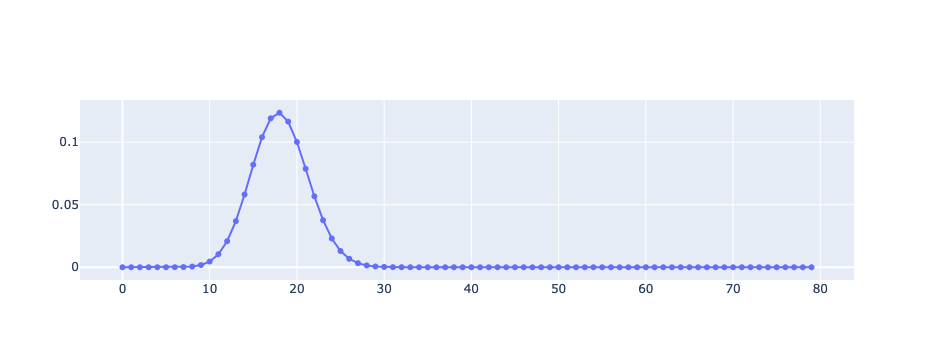

In [369]:
go.Figure(
    data=go.Scatter(x=df0.num_adm_pred, y=df0.probs, mode='lines+markers')
)

### Plot multiple forecasts from the same time the last 28ish days

In [370]:
#dfr = df recent (same hour, same day of the week)
dfr = df.loc[((df.hour==df0.iloc[0].hour) & (df.dow==df0.iloc[0].dow)),['days',  'num_adm_pred', 'probs']]


In [372]:
dfr.days.value_counts()

28    101
21    100
0      80
7      77
14     56
Name: days, dtype: int64

Using the [ridgeplot](https://github.com/tpvasconcelos/ridgeplot) package which in turn also uses plotly for this. We need to prepare the data as a series of (2,n) arrays for this where 'n' is the same for all densities.

Prepare a list of days (should be multiples of 7 into the past)

In [395]:
days = dfr.days.unique()
days = days[np.argsort(-days)]

In [391]:
num_adm_max = dfr.num_adm_pred.max()
skeleton = pd.DataFrame(dict(num_adm_pred=range(num_adm_max)))
ll = []

for day in days:
    tt = dfr.loc[dfr.days==day].drop(['days'],axis=1)
    tt = pd.merge(skeleton, tt, how='left')
    tt = tt.reset_index(drop=True)
    tt = tt.loc[:40,]
    tt = tt.values.transpose()
    ll.append(tt)
res = np.asarray(ll)

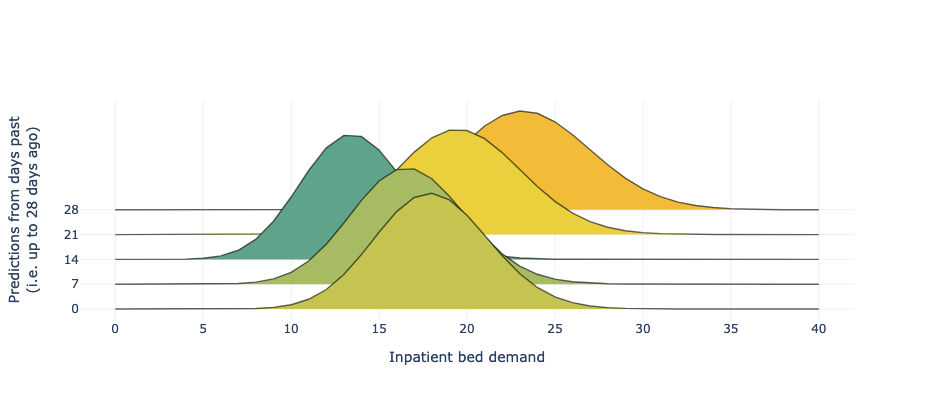

In [394]:
fig = ridgeplot(densities=res, 
                labels=days,
                colorscale='portland',
                colormode='mean-minmax',
                spacing=1/5,
               )
fig.update_layout(showlegend=False)
fig.update_layout(autosize=False, width=800, height=400)
fig.update_layout(xaxis_title='Inpatient bed demand',
                 yaxis_title="Predictions from days past<br>(i.e. up to 28 days ago)")
fig.update_layout(template='plotly_white')
fig.show()